# Machine Learning Project: Predicting a film’s gross revenue

In [4]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_selection import  mutual_info_regression, SelectKBest
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

from pandas.plotting import scatter_matrix
import seaborn as sns


In [243]:
# loading the data

X1 = pd.read_csv("X1.csv" )
Y1 = pd.read_csv("Y1.csv" , header=None , names =["revenue"])

### Preprocessing of data

In [ ]:
def DataPreProcessing(dataframe):

    dataframe.insert(10, "genre3", "")
    dataframe.insert(10, "genre2", "")
    dataframe.insert(10, "genre1", "")

    genre_individual(dataframe)
    
    toDrop = ["Unnamed: 0", "title", "img_url", "description", "genres", "is_adult"]
    for col in toDrop :
        dataframe=dataframe.drop(col,axis=1)

    dataframe = fillRuntime(dataframe)  # fill empty runtime with NaN values
    dataframe = weightedGenres(dataframe) # weighted on-hot encoding of genres
    dataframe = oneHotStudio(dataframe)
    dataframe = processEmbeddings(dataframe)
    return dataframe
    #    directorAndActors(dataframe)

def fillRuntime(dataframe):

    averageTimeByGenre = {}
    for i in range (len (dataframe["genre1"].unique())):
        averageTimeByGenre[dataframe["genre1"].unique()[i]] = 0
    
    for i in range (len (dataframe["runtime"])):
        if (dataframe["runtime"][i] != '\\N'):
            averageTimeByGenre[dataframe["genre1"][i]]+= int(dataframe["runtime"][i])            
            
    for i in range (len (dataframe["genre1"].unique())):
        averageTimeByGenre[dataframe["genre1"].unique()[i]] /= dataframe["genre1"].value_counts()[dataframe["genre1"].unique()[i]]     

    for i in range (len (dataframe["genre1"])):
        if dataframe["runtime"][i] == '\\N':
            dataframe["runtime"][i] = int(averageTimeByGenre[dataframe["genre1"][i]])
        else: 
            dataframe["runtime"][i] = int(dataframe["runtime"][i])
    return dataframe

def weightedGenres(dataframe):

    ListOfGenre = list(set(list(dataframe["genre1"].unique()) + list(dataframe["genre2"].unique()) + list(dataframe["genre3"].unique())))

    ListOfGenre.remove("")
    ListOfGenre.remove('\\N')
    
    for i in range (len(ListOfGenre)):
        dataframe[ListOfGenre[i]] = 0

    for i in range (len(dataframe["genre1"])):
        if dataframe["genre1"][i] != "\\N":
            dataframe[dataframe["genre1"][i]][i] = 3
            
    for i in range (len(dataframe["genre2"])):
        if dataframe["genre2"][i] != "\\N" and dataframe["genre2"][i] != "":
            dataframe[dataframe["genre2"][i]][i] = 2
            
    for i in range (len(dataframe["genre3"])):
        if dataframe["genre3"][i] != "\\N" and dataframe["genre3"][i] != "":
            dataframe[dataframe["genre3"][i]][i] = 1
            
    dataframe=dataframe.drop("genre1",axis=1)
    dataframe=dataframe.drop("genre2",axis=1)
    dataframe=dataframe.drop("genre3",axis=1)

    return dataframe

def oneHotStudio(dataframe):

    # Count the number of occurrences of each category
    counts = dataframe["studio"].value_counts()

    # Sort the categories by their frequency in descending order
    counts = counts.sort_values(ascending=False)
    k = 9
    # Select the k most represented categories
    top= counts[:k].index

    # Apply binary encoding to the selected categories
    dataframe = pd.get_dummies(dataframe, columns=['studio'], prefix='std', prefix_sep='_', dummy_na=False)
    for col in dataframe.columns:
        if col[0:3] == "std":
            if(col[4:] not in top):
                dataframe.drop(col, axis=1, inplace=True)

    return dataframe

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def genre_individual(dataset):
    for i in range (len(dataset["genres"])):
        genres_here = dataset["genres"][i].split(",")
        for j in range(len(genres_here)):
            name = "genre"+str(j+1)
            dataset.loc[i, name]=genres_here[j]

    return dataset

def processEmbeddings(dataframe):

    for i in range (len(dataframe)):
        LaList = dataframe['text_embeddings'][i][1:][:-1].split(',')
        dataframe['text_embeddings'][i] = [float(item) for item in LaList]

    for i in range (len(dataframe)):
        LaList = dataframe['img_embeddings'][i][1:][:-1].split(',')
        dataframe['img_embeddings'][i] = [float(item) for item in LaList]

    return dataframe

def directorAndActors(dataset):
    actorsList = []
    directorList = []
    for i in range (len(dataset["description"])):
        print("\r"+str(i), end= "")
        step1= remove_prefix(dataset["description"][i], dataset["title"][i] + ": ")
        step2= step1.split('. ')
        if ("Directed " in step2[0]):
            step3= remove_prefix(step2[0], "Directed by ")
            if (step3 not in directorList):
                directorList.append(step3)
                dataset[step3] = 0
            dataset.at[i, step3] = 1
            
        elif ("With" in step2[0]):
            step4= remove_prefix(step2[0], "With ").split(', ')
        if (len(step2) >=2):
            if ("With" in step2[1]):
                step4= remove_prefix(step2[1], "With ").split(', ')
            
        
        for j in range (len(step4)):
            if step4[j] not in actorsList:
                actorsList.append(step4[j])
                dataset[step4[j]] = 0
                dataset.at[i, step4[j]] = 1
            else :
                dataset.at[i, step4[j]] = 1
    return actorsList

def color_Dico():
    genres = set()

    for i in range (len(X1["genres"])):
        for j in range (len(X1["genres"][i].split(","))):
            genres.add(X1["genres"][i].split(",")[j])
    
    rgb_values = sns.color_palette("Set2", 27)
    dico = {}
    for i in range (len(genres)):
        dico[genres.pop()]=rgb_values[i]
    return dico


X1 = DataPreProcessing(X1)

### Dimensionnality reduction of embeddings

In [216]:

def compute_embedding(X, dim, embedName='text', save=False, savePath=None):

    """ computes embeddings and saves them if saves = True"""
    data = ToNpArray(X["%s_embeddings"%(embedName)])
    data = StandardScaler().fit_transform(data)  # scaling the data
    emb = TSNE(n_components=dim, random_state=42, method='exact').fit_transform(data)
    if save == True:
        np.save(savePath, emb)

    return emb

def fill_embedding(X, embedValues, dim, embedName='img'):
    """"""
    X.drop("%s_embeddings"%(embedName), axis=1, inplace=True)
    for i in range(dim):
        X["%s_embeddings%d"%(embedName, i)] = embedValues[:,i]

def ToNpArray(pdSeries):
    
    list = pdSeries.tolist()
    npArray = np.array(list) 
    return npArray

### Feature and model selection 

In [265]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from sklearn.neural_network import MLPRegressor
import time
import random
import sys


In [269]:
# Initialize data

X1 = pd.read_csv("processedData/st9im3txt3", index_col=0)
Y1 = pd.read_csv("Y1.csv", header=None , names =["revenue"])

X = X1.to_numpy()
y = Y1.to_numpy().ravel()

eval_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=eval_size, random_state=42)
X1_train = pd.DataFrame(X_train, columns=X1.columns)
X1_test = pd.DataFrame(X_test, columns=X1.columns)



### Filter methods

In [273]:

# feature selection using min redundancy max relevance approach

def minRedMaxRel(X1_train, y, k):

    """ feature selection using min redundancy max relevance approach"""
    available = list(X1.columns)
    selected = []
    corrThreshold = 0.6
    for i in range(k):

        if(len(available) == 0):
            break
        mi = np.argsort(mutual_info_regression(X1_train[available].to_numpy(), y))
        best = available[mi[-1]]
        selected.append(best)
        for av in available:     
            corrcoeff, _ = pearsonr(X1_train[av].to_numpy(), X1_train[best].to_numpy())
            if corrcoeff > corrThreshold:
                available.remove(av)

    return X1_train[selected].to_numpy(), selected


def Kbest(X1, Y1, k):

    """"select k best based on mutual information, does not look at correlation """
    available = list(X1.columns)   
    selected = []
    mi = np.argsort(mutual_info_regression(X1[available].to_numpy(), Y1.to_numpy().ravel()))
    for i in range(k):
        best = available[mi[-i]]
        selected.append(best)

    return X1[selected], selected


### Model selection

In [ ]:
nbFeatures = [10, 15, 20, 25, 30, 35]

RMSE = {}
RMSE["LR"] = {}
RMSE["DF"] = []
RMSE["MLP"] = {}
RMSE["KNN"] = []

def Kfoldfit(X, y, k, model):
    
    """Applies Kfold with model """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    MSE = []
    rel_error = []

    for train_index, test_index in kfold.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        ypred = model.predict(X_test)

        mse = mean_squared_error(ypred, y_test)
        MSE.append(mse)

        score = model.score(X_test, y_test)
        scores.append(score)

    rmse = np.sqrt(np.mean(MSE))
    mean_score = np.mean(scores)
    return mean_score, rmse

def filterModelSelection(X, y, nbFeatures, RMSE):

    """ evaluates models with selected features """


    neighbors = np.arange(4, 25, 2)
    
    n_estimators = [25, 50, 100, 150, 200]
    for f in nbFeatures:
        X,_ = minRedMaxRel(X1_train, y, f)

        # KNN
        start = time.perf_counter()
        for k in neighbors:
            model = KNeighborsRegressor(k)
            _, rmse = Kfoldfit(X, y, 10, model)
            RMSE["KNN"].append((f, k, rmse))
        print("time taken by KNN : %f"%(time.perf_counter() - start))

        # #Linear regression
        model = LinearRegression()
        _, rmse = Kfoldfit(X, y, 10, model)
        RMSE["LR"][f] = (f, rmse)

        # # Random forests
        start = time.perf_counter()
        for n in n_estimators:
            model = RandomForestRegressor(n)
            _, rmse = Kfoldfit(X, y, 10, model)
            RMSE["DF"].append((f, n, rmse))
        print("time taken by RF : %f"%(time.perf_counter() - start))

        #MLP
        start = time.perf_counter()
        model = MLPRegressor(max_iter=300)
        _ , rmse = Kfoldfit(X, y, 10, model)
        RMSE["MLP"][f] = (f, rmse)
        print("time taken by MLP : %f"%(time.perf_counter() - start))

    return RMSE

filterModelSelection(X_train, y_train, nbFeatures, RMSE)

with open('results/filterResults.txt', 'w') as f:
    f.write("\n KNN : \n")
    f.write(str(RMSE))



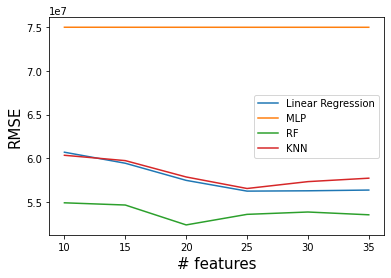

In [292]:
# _________________________________ PLOTTING _________________________________________


# overal performances
def plotOveralPerf(RMSE):
    x = [10, 15, 20, 25, 30, 35]
    LR = [rmse for (f, rmse) in RMSE["LR"].values()]
    MLP = [rmse for (f, rmse) in RMSE["MLP"].values()]
    RF = []
    for (f, n, rmse) in RMSE["DF"]:
        if n == 200:
            RF.append(rmse)

    KNN = []
    for (f, k, rmse) in RMSE["KNN"]:
        if k == 14:
            KNN.append(rmse)

    fig, ax = plt.subplots()
    ax.plot(x, LR, label="Linear Regression")
    ax.plot(x, MLP, label="MLP")
    ax.plot(x, RF, label="RF")
    ax.plot(x, KNN, label="KNN")
    ax.set_ylabel("RMSE", size=15)
    ax.set_xlabel("# features", size= 15)

    ax.legend()
    ax.set_xticks(x)
    plt.plot()
    plt.savefig("figures/filterPerfs.pdf")

def plotRFperfs(RMSE):
    x = [25, 50, 100, 150, 200]
    DF10 = []
    DF15 = []
    DF20 = []
    DF25 = []
    DF30 = []
    DF35 = []
    for (nfeat, n_estimators, rmse) in RMSE["DF"]:
        if nfeat == 10:
            DF10.append(rmse)
        elif nfeat == 15:
            DF15.append(rmse)
        elif nfeat == 20:
            DF20.append(rmse)
        elif nfeat == 25:
            DF25.append(rmse)
        elif nfeat == 30:
            DF30.append(rmse)
        else:
            DF35.append(rmse)


    fig, ax = plt.subplots()
    ax.plot(x,DF10, label="10 features")
    ax.plot(x, DF15, label="15 features")
    ax.plot(x,DF20, label="20 features")
    ax.plot(x, DF25, label="25 features")
    ax.plot(x, DF30, label="30 features")
    ax.plot(x, DF35, label="35 features")

    ax.set_ylabel("RMSE", size=15)
    ax.set_xlabel("# estimators", size= 15)
    ax.set_title("Random Forests performances")
    ax.legend()
    ax.set_xticks(x)
    plt.savefig("figures/filterRF.pdf")
    plt.plot()

def plotKNNperfs(RMSE):
    x =np.arange(4, 25, 2)
    KNN10 = []
    KNN15 = []
    KNN20 = []
    KNN25 = []
    KNN30 = []
    KNN35 = []
    for (nfeat, n_estimators, rmse) in RMSE["KNN"]:
        if nfeat == 10:
            KNN10.append(rmse)
        elif nfeat == 15:
            KNN15.append(rmse)
        elif nfeat == 20:
            KNN20.append(rmse)
        elif nfeat == 25:
            KNN25.append(rmse)
        elif nfeat == 30:
            KNN30.append(rmse)
        else:
            KNN35.append(rmse)

    fig, ax = plt.subplots()
    ax.plot(x,KNN10, label="10 features")
    ax.plot(x, KNN15, label="15 features")
    ax.plot(x,KNN20, label="20 features")
    ax.plot(x, KNN25, label="25 features")
    ax.plot(x, KNN30, label="30 features")
    ax.plot(x, KNN35, label="35 features")
    ax.set_ylabel("RMSE", size=15)
    ax.set_xlabel("# neighbors", size= 15)
    ax.set_title("KNN performances")
    ax.legend()
    ax.set_xticks(x)
    plt.plot()
    plt.savefig("figures/filterKNN.pdf")

#plotOveralPerf(RMSE)
#plotRFperfs(RMSE)
#plotKNNperfs(RMSE)

### Model evaluation

In [295]:
# Random forests
nfeatures = 20
X_selected, features = minRedMaxRel(X1_train, y_train, nfeatures)

n_estimators = 50  # this is equal to best_n found in above cell

inst = 10
meanRMSE = 0
for i in range(inst):
    model = RandomForestRegressor(n_estimators)
    model.fit(X1_train[features], y_train)
    meanRMSE += mean_squared_error(y_test, model.predict(X1_test[features]))

meanRMSE /=inst
meanRMSE = np.sqrt(meanRMSE)
print(meanRMSE)

63263944.99058031


### Wrapper method (brute force)

In [171]:

# HELPER FUNCTIONS FOR FEATURE SELECTION

def find_init(X1_fit, y, nbStart, obj, margin):

    """"finds initial feature subset guesses"""
    features = X1.columns
    total = len(features)
    selected = []
    # sorting features according to mutual information
    mi = np.argsort(mutual_info_regression(X1_fit[features].to_numpy(), y))
    mi = np.flip(mi)
    # automatically taking nbStart features
    for i in mi[0:nbStart]:
        selected.append(features[i])

    # adding features according to mutual information until it does not decrease anymore

    RMSE= sys.float_info.max

    for i in range(nbStart, total):      # adding features until model does not improve
        start = time.perf_counter()
        toAdd = features[mi[i]]
        selected.append(toAdd)
        rmse = obj(selected)             # we only keep the minimum RMSE
        print("time taken for %fth iteration : %f"%(i, time.perf_counter() - start))

        if(rmse - margin > RMSE):
            selected.remove(toAdd)
            break
        RMSE = np.min((rmse, RMSE))
    return selected

# Local search for feature selection 

def multi_hill_climbing(obj, visited, max_iter, init, X1_train, k, d):
    """
        apply hill climbing from different sets in init
    """
    # Initialize the current solution to a random point within the feasible region
    selected = init
    selRMSE = [obj(guess) for guess in init]
    results = np.zeros((len(init), max_iter))

    available = X1_train.columns
        # Iterate over a set number of iterations
    for i in range(max_iter):
  
        for k in range(len(init)):
            start = time.perf_counter()
            # Generate a set of candidate solutions by making small changes to the current solution
            candidates = [selected[k]]  # we keep previous solutions 
            candRMSE = [selRMSE[k]]
            if(len(selected[k]) == len(available)):
                pass
            else : 
                for j in range(d):
                    candidate = generate_mutated(selected[k], available)
                    if candidate not in visited:
                        candRMSE.append(obj(candidate))
                        candidates.append(candidate)
                        visited.append(candidate)

            sel_ind = np.argsort(candRMSE)[0] 
            selected[k] = candidates[sel_ind]
            selRMSE[k] = candRMSE[sel_ind] 
            results[k, i] = selRMSE[k]
            print("HILL CLIMBING ITERATION iteration : %f"%(time.perf_counter() - start))

    return selected, selRMSE, results

def generate_mutated(elem, neighborhood):

    candidate = elem.copy()
    while(True):
        pick = random.choice(neighborhood)
        if(pick not in elem):
            candidate[random.randint(0, len(elem)-1)] = pick
            break
    return candidate
    
def RFRMSE(feature_set):

    RMSE = sys.float_info.max
    model = RandomForestRegressor(100)
    _, rmse = Kfoldfit(X_train, y_train, 10, model)
    RMSE = np.min([RMSE, rmse])
    return RMSE

def LRRMSE(feature_set):

    model = LinearRegression()
    _, rmse = Kfoldfit(X_train, y_train, 10, model)    
    return rmse

def KNNRMSE(feature_set):
    
    model = KNeighborsRegressor(15)
    _, rmse = Kfoldfit(X_train, y_train, 10, model)    
    return rmse



In [ ]:
# ________________________________  FEATURE SELECTION ______________________________________
visited = []
k = 3
d = 3
max_iter = 80

margin = [0, 300000, 450000, 600000]

# Random forests

initRF = []
iterates = []
min = 20
for marg in margin:
        guess = find_init(X1_train, y_train, min, RFRMSE, marg)
        min = len(guess)
        initRF.append(guess)
selectRF, MRSERF, resultsRF = multi_hill_climbing(RFRMSE, visited, max_iter, initRF, X1_train, k, d)

with open('results/wrapperRFV2.txt', 'w') as f:
    f.write("\nRandom Forests : \n")
    f.write(str(selectRF))
    f.write("\n")
    f.write(str(MRSERF))
    f.write("\n iterates :\n ")
    f.write(str(resultsRF))
# KNN
visited = []
initKNN = []
min = 20
for marg in margin:
        guess = find_init(X1_train, y_train, min, KNNRMSE, marg)
        min = len(guess)
        initKNN.append(guess)

selectKNN, MRSEKNN, resultsKNN = multi_hill_climbing(KNNRMSE, visited, max_iter, initKNN, X1_train, k, d)

with open('results/wrapperKNNV2.txt', 'w') as f:
    f.write("\n KNN : \n")
    f.write(str(selectKNN))
    f.write("\n")
    f.write(str(MRSEKNN))
    f.write("\n iterates :\n ")
    f.write(str(resultsKNN))

# Linear regression

visited = []
initLR = []
min = 20
for marg in margin:
        guess = find_init(X1_train, y_train, min, LRRMSE, marg)
        min = len(guess)
        initLR.append(guess)

selectLR, MRSELR, resultsLR = multi_hill_climbing(LRRMSE, visited, max_iter, initLR, X1_train, k, d)

with open('results/wrapperLRV2.txt', 'w') as f:

    f.write("\n Linear Regression \n")
    f.write(str(selectLR))
    f.write("\n")
    f.write(str(MRSELR))
    f.write("\n iterates :\n ")
    f.write(str(resultsLR))


### Model selection for wrapper

In [176]:
# ________________________________  MODEL SELECTION ______________________________________

# Random forests

n_estimators = np.arange(100, 326, 25)
RMSE_n = []

best = np.argmin(MRSERF)
selected = selectRF[best]
best_n = 100
best_rmseRF = MRSERF[best]

for n in n_estimators:
    model = RandomForestRegressor(n)
    _, rmse = Kfoldfit(X_train, y_train, 10, model)
    RMSE_n.append(rmse)
    if(rmse < best_rmseRF):
        best_n = n
        best_rmseRF = rmse

k_neighbors = np.arange(10, 30, 2)
RMSE_k = []
best = np.argmin(MRSEKNN)
selected = selectKNN[best]
best_k = 15
best_rmseKNN = MRSEKNN[best]

for k in k_neighbors:
    model = KNeighborsRegressor(k)
    _, rmse = Kfoldfit(X_train, y_train, 10, model)
    RMSE_k.append(rmse)
    if(rmse < best_rmseKNN):
        best_k = k
        best_rmseKNN = rmse   


with open('results/hypertuningV2.txt', 'w') as f:
    f.write("\nRandom Forests : \n")
    f.write(str(best_n))
    f.write("\n")
    f.write(str(best_rmseRF))
    f.write("\n")
    f.write(str(RMSE_n))
    f.write("\n KNN : \n")
    f.write(str(best_k))
    f.write("\n")
    f.write(str(best_rmseKNN))
    f.write("\n")
    f.write(str(RMSE_k))


### Model evaluation

In [262]:
# Random forests

features = ['n_votes', 'release_year', 'production_year', 'runtime', 'ratings', 'Drama', 'text_embeddings0', 
'Comedy', 'text_embeddings1', 'text_embeddings2', 'Adventure', 'Documentary', 'img_embeddings0', 'Action', 
'std_WB', 'std_Uni.', 'std_Par.', 'Crime', 'std_BV', 'Thriller', 'img_embeddings1', 'std_Fox', 'std_Sony', 
'img_embeddings2', 'std_IFC', 'Mystery', 'Romance', 'std_Mira.', 'Sci-Fi', 'std_MGM', 'Horror', 'Biography', 
'Game-Show', 'Music', 'Animation', 'Short', 'Fantasy', 'Musical', 'Film-Noir', 'History']

n_estimators = 100  # this is equal to best_n found in above cell
model = RandomForestRegressor(n_estimators)

# evaluating the model

n_estimators = 100  # this is equal to best_n found in above cell
inst = 10
meanRMSE = 0
for i in range(inst):
    model = RandomForestRegressor(n_estimators)
    model.fit(X1_train[features], y_train)
    meanRMSE += mean_squared_error(y_test, model.predict(X1_test[features]))

meanRMSE /=inst
meanRMSE = np.sqrt(meanRMSE)
print(meanRMSE)

65128757.37411713


In [257]:
# Linear regression run this cell OR the one above

features = X1.columns
model = LinearRegression()
model.fit(X1_train[features], y_train)
rmse = mean_squared_error(y_test, model.predict(X1_test[features]))
print(np.sqrt(rmse))

67603697.28218523


In [264]:
# KNN

features =  ['n_votes', 'release_year', 'production_year', 'runtime', 'ratings', 'Drama', 'text_embeddings0', 'Comedy', 
'text_embeddings1', 'text_embeddings2', 'Adventure', 'Documentary', 'img_embeddings0', 'Action', 'std_WB', 'std_Uni.', 
'std_Par.', 'Crime', 'std_BV', 'Thriller', 'img_embeddings1', 'std_Fox', 'std_Sony', 'img_embeddings2', 'std_IFC', 
'Mystery', 'Romance', 'std_Mira.', 'Sci-Fi', 'std_MGM', 'Horror', 'Biography', 'Family', 'Music', 'Animation', 'Short', 
'Fantasy', 'Musical', 'Film-Noir', 'History', 'War', 'Reality-TV', 'News', 'Western', 'Sport', 'Game-Show']

print(len(features))
model = KNeighborsRegressor(14)
model.fit(X1_train[features], y_train)
rmse = mean_squared_error(y_test, model.predict(X1_test[features]))
print(np.sqrt(rmse))

46
74555527.77419351


### Prediction of X2

In [ ]:
# Model used

n_estimators = 50
model = RandomForestRegressor(n_estimators)

In [ ]:
# preprocessing X2

X2 = pd.read_csv("X2.csv" )
X2 = DataPreProcessing(X2)

# adding missing genres and studios
columns = list(X2.columns)
for feat in features:
    if feat not in columns:
        X2[feat] = 0

In [249]:
# Making the prediction

textembedX2 = np.load("embed/X2txt3.npy")       #compute_embedding(X2, 3, embedName='text', save=True, savePath="embed/X2txt3.npy")
imgembedX2 = np.load("embed/X2img3.npy")   #compute_embedding(X2, 3, embedName='img', save=True, savePath="embed/X2img3.npy")
fill_embedding(X2, textembedX2, 3, embedName='text')
fill_embedding(X2, imgembedX2, 3, embedName='img')

predX2 = model.predict(X2[features].to_numpy())
